In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [ ]:
# ===============================
# PARÂMETROS PRINCIPAIS
# ===============================
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

EPOCHS_FREEZE = 15      # base congelada
EPOCHS_FINE_TUNE = 20   # fine-tuning

VALIDATION_SPLIT = 0.20
DATA_DIR = 'data/16_animes' 

# Configurar GPU (se disponível)
# Isso porque o código foi executado em ambientes diferentes devido a composição do grupo e tipo de maquina de cada um
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Erro ao configurar GPU: {e}")

In [ ]:
# ===============================
# Dados gerais do dataset
# ===============================
def get_class_names(data_dir):
    # Lista ordenada dos nomes das classes com base nas pastas
    return sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

class_names = get_class_names(DATA_DIR)
NUM_CLASSES = len(class_names)

def count_images(data_dir):
    total = 0
    dist = {}
    for cls in class_names:
        path = os.path.join(data_dir, cls)
        count = len([f for f in os.listdir(path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        dist[cls] = count
        total += count
    return total, dist

total_images, class_distribution = count_images(DATA_DIR)
print(f"Total de imagens: {total_images}")
print(f"Distribuição por classe: {class_distribution}")

In [ ]:
# ===============================
# CALCULAR CLASS WEIGHTS
# ===============================
all_labels = []
for idx, cls in enumerate(class_names):
    all_labels += [idx] * class_distribution[cls]
all_labels = np.array(all_labels)
# Gera pesos para classes desbalanceadas, importante para conjuntos não uniformes
cls_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(cls_weights))
print("Class weights:", class_weights)

In [ ]:
# ===============================
# DATA AUGMENTATION E GERADORES
# ===============================
# Data augmentation aumenta variedade do dataset sinteticamente, ajudando na generalização
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=25,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.15,
    zoom_range=0.20,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=VALIDATION_SPLIT
)
# Geração de batches de imagens para treino e validação (com split)
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

print(f"Imagens de treino: {train_generator.samples}")
print(f"Imagens de validação: {validation_generator.samples}")

In [ ]:
# ===============================
# DEFINIÇÃO DO MODELO
# ===============================
def create_model():
    # Cria o modelo EfficientNetB0 com camadas customizadas no topo
    # Uso de regularização, batchnorm e dropout para evitar overfitting
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.Lambda(tf.keras.applications.efficientnet.preprocess_input)(inputs)

    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_tensor=x,
        drop_connect_rate=0.2
    )
    base_model.trainable = False # Congela pesos do backbone no início

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)   # Dropout reduzido para 0.3

    x = layers.Dense(
        128,  # 128 unidades no topo
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)   # Dropout reduzido para 0.2

    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model, base_model

model, base_model = create_model()

# Métricas adicionais
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compilar com base congelada
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=metrics
)

print("Resumo da arquitetura:")
model.summary()

In [ ]:

# ===============================
# CALLBACKS
# ===============================
# Callbacks para: salvar melhor modelo, ajustar taxa de aprendizado e evitar overfitting

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_anime_classifier.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=1e-7,
    verbose=1
)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
# ===============================
# TREINAMENTO - FASE 1: BASE CONGELADA
# ===============================

steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
validation_steps = max(1, validation_generator.samples // BATCH_SIZE)

print("\n=== FASE 1: Treinamento com base congelada ===")
# Treina apenas o topo do modelo, mantendo EfficientNetB0 congelada
history_freeze = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS_FREEZE,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weights,     # # ameniza desbalanceamento
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

In [ ]:
# ===============================
# TREINAMENTO - FASE 2: FINE-TUNING
# ===============================
# Fine-tuning: libera parte das camadas finais para adaptação ao dataset
base_model.trainable = True
# Ajustar para liberar a partir de um bloco intermediário (layer 250)
fine_tune_at = 250
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompilar com learning rate menor
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

print("\n=== FASE 2: Fine-tuning a partir de layer 250 ===")
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[checkpoint, reduce_lr, early_stop],
    verbose=1
)

In [ ]:
# ===============================
# COMBINAR HISTÓRICOS E PLOTAR GRÁFICOS
# ===============================
def combine_histories(hist1, hist2):
    combined = {}
    for h in (hist1, hist2):
        for key, values in h.history.items():
            if key not in combined:
                combined[key] = []
            combined[key].extend(values)
    return type('History', (), {'history': combined})()

history_combined = combine_histories(history_freeze, history_fine)

def plot_training_evolution(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b-',  label='Training Accuracy', linewidth=2)
    plt.plot(epochs, history.history['val_accuracy'], 'r-',  label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-',  label='Training Loss', linewidth=2)
    plt.plot(epochs, history.history['val_loss'], 'r-',  label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Exibir gráficos de evolução
plot_training_evolution(history_combined)

In [ ]:
# ===============================
# AVALIAÇÃO FINAL
# ===============================
print("\n=== Avaliação no conjunto de validação ===")
# Avalia desempenho final do modelo na validação, calcula métricas principais e mostra relatório detalhado
val_loss, val_acc, val_prec, val_rec = model.evaluate(validation_generator, verbose=1)
f1_score = 2 * (val_prec * val_rec) / (val_prec + val_rec + 1e-8)

print(f"Loss:      {val_loss:.4f}")
print(f"Accuracy:  {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall:    {val_rec:.4f}")
print(f"F1-Score:  {f1_score:.4f}")

# Predições detalhadas
validation_generator.reset()
pred_probs = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = validation_generator.classes

print("\n=== Relatório de Classificação ===")
# Matriz de confusão para análise de erros por classe
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i,j]}\n({cm_perc[i,j]:.1f}%)"

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Número de Predições'})
plt.title('Matriz de Confusão - Ajustada', fontsize=14)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

In [ ]:
# ===============================
# FUNÇÃO DE PREDIÇÃO
# ===============================
def predict_anime(model, image_path, class_names, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, top_k=3):
    # Função utilitária para predizer a classe de uma nova imagem e mostrar as top-k predições
    try:
        img = keras.preprocessing.image.load_img(
            image_path, target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, 0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        preds = model.predict(img_array, verbose=0)[0]
        top_indices = np.argsort(preds)[::-1][:top_k]

        print(f"\nPredições para '{image_path}':")
        for rank, idx in enumerate(top_indices, start=1):
            conf = preds[idx]
            print(f"{rank}º: {class_names[idx]}  -  {conf:.4f} ({conf*100:.2f}%)")

        return {
            'top_prediction': class_names[top_indices[0]],
            'confidence': preds[top_indices[0]],
            'all_predictions': [(class_names[i], preds[i]) for i in top_indices]
        }

    except Exception as e:
        print(f"Erro na predição: {e}")
        return None

Total de imagens: 1140
Distribuição por classe: {'Dragon Ball Z': 380, 'My Hero Academia': 380, 'Naruto': 380}
Class weights: {0: 1.0, 1: 1.0, 2: 1.0}
Found 912 images belonging to 3 classes.
Found 228 images belonging to 3 classes.
Imagens de treino: 912
Imagens de validação: 228
Resumo da arquitetura:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda_4 (Lambda)           (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 rescaling_8 (Rescaling)     (None, 224, 224, 3)          0         ['lambda_4[0][0]

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 47s 1s/step - loss: 0.6399 - accuracy: 0.7489 - precision: 0.7791 - recall: 0.7156 - val_loss: 0.5453 - val_accuracy: 0.7723 - val_precision: 0.8267 - val_recall: 0.7455 - lr: 1.0000e-05
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.7364 - precision: 0.7576 - recall: 0.7102
Epoch 2: val_accuracy did not improve from 0.77232
28/28 [==============================] - 39s 1s/step - loss: 0.6794 - accuracy: 0.7364 - precision: 0.7576 - recall: 0.7102 - val_loss: 0.5432 - val_accuracy: 0.7723 - val_precision: 0.8244 - val_recall: 0.7545 - lr: 1.0000e-05
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.7250 - precision: 0.7494 - recall: 0.6932
Epoch 3: val_accuracy improved from 0.77232 to 0.77679, saving model to best_anime_classifier.h5
28/28 [==============================] - 39s 1s/step - loss: 0.6874 - accuracy: 0.7250 - precision: 0.7494 - recall: 0.6932 - val_loss

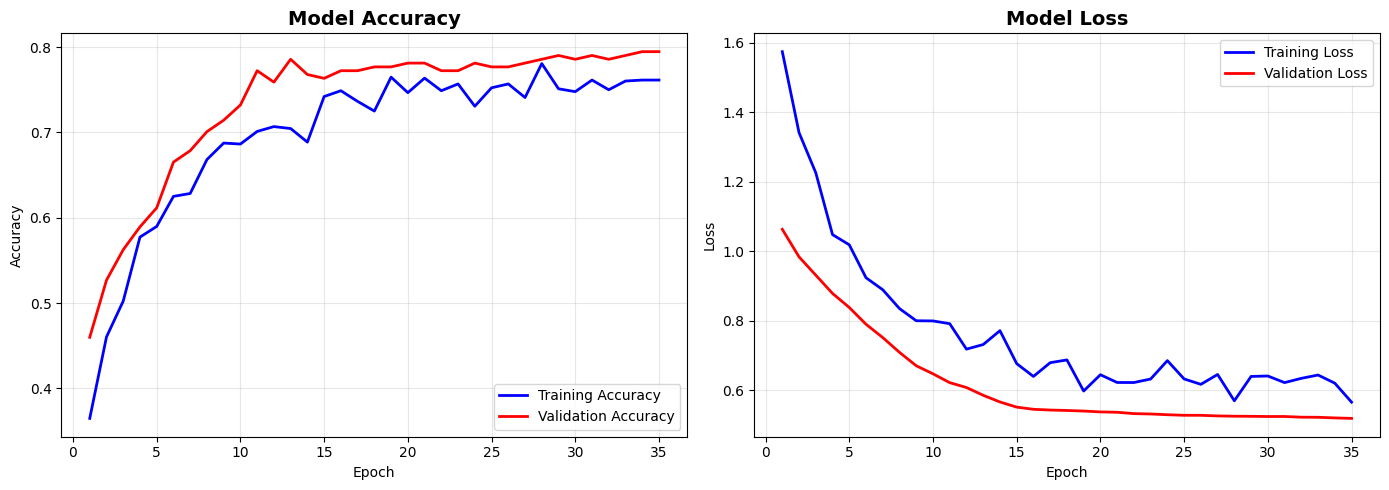


=== Avaliação no conjunto de validação ===
8/8 [==============================] - 7s 887ms/step - loss: 0.5176 - accuracy: 0.7982 - precision: 0.8286 - recall: 0.7632
Loss:      0.5176
Accuracy:  0.7982
Precision: 0.8286
Recall:    0.7632
F1-Score:  0.7945
8/8 [==============================] - 9s 877ms/step

=== Relatório de Classificação ===
                  precision    recall  f1-score   support

   Dragon Ball Z     0.7910    0.6974    0.7413        76
My Hero Academia     0.8272    0.8816    0.8535        76
          Naruto     0.7750    0.8158    0.7949        76

        accuracy                         0.7982       228
       macro avg     0.7977    0.7982    0.7965       228
    weighted avg     0.7977    0.7982    0.7965       228



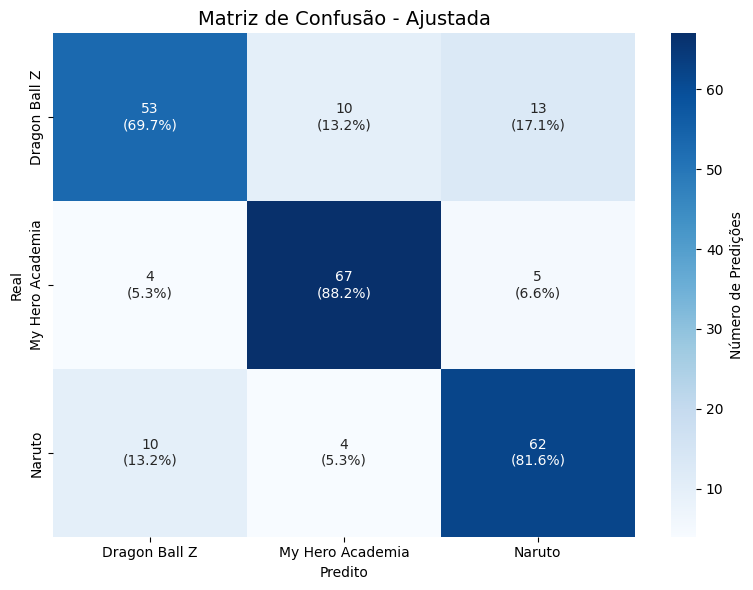


Resumo do Classificador de Anime (EfficientNetB0 - Ajustado)
Classes: ['Dragon Ball Z', 'My Hero Academia', 'Naruto']
Total de Imagens: 1140
Distribuição: {'Dragon Ball Z': 380, 'My Hero Academia': 380, 'Naruto': 380}
Acurácia Final:  79.82%
Precision:       82.86%
Recall:          76.32%
F1-Score:        79.45%
❌ Meta não atingida

Memória limpa. Treinamento concluído com sucesso!
Modelo salvo como 'best_anime_classifier.h5'.


In [ ]:
# ===============================
# RESUMO FINAL
# ===============================
print("\n" + "="*50)
print("Resumo do Classificador de Anime (EfficientNetB0 - Ajustado)")
print(f"Classes: {class_names}")
print(f"Total de Imagens: {total_images}")
print(f"Distribuição: {class_distribution}")
print(f"Acurácia Final:  {val_acc*100:.2f}%")
print(f"Precision:       {val_prec*100:.2f}%")
print(f"Recall:          {val_rec*100:.2f}%")
print(f"F1-Score:        {f1_score*100:.2f}%")
status = "✅ Meta 95% atingida" if val_acc >= 0.95 else "❌ Meta não atingida"
print(status)
print("="*50)

# Limpeza de memória
gc.collect()
print("Modelo salvo como 'best_anime_classifier.h5'.")